In [1]:
"""
Trains a Segmentalist model on a dataset and saves the resulting model checkpoints.


"""
import re
import operator
import logging
import pickle
import time
import argparse

import rasterio
import numpy as np
import matplotlib.pyplot as plt
import dask
import dask.array as da
import tensorflow as tf
import tensorflow_addons as tfa
import kerastuner as kt
import sys
import pprint
import yaml
import uuid
import albumentations as A
import joblib 

import gim_cv.config as cfg
import gim_cv.utils as utils
import gim_cv.losses as losses
import gim_cv.datasets as datasets
import gim_cv.tools.keras_one_cycle_clr as clr

from functools import partial, reduce
from pathlib import Path
from time import perf_counter as pc

#from sklearn.externals import joblib
from tensorflow.keras.models import load_model
from distributed import Client, LocalCluster
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow_addons.optimizers import SWA
#from zarr.errors import ArrayNotFoundError

from gim_cv.models.segmentalist import Segmentalist
from gim_cv.training import TrainingDataset, pair_batch_generator, CompositeTrainingDataset, fancy_batch_generator
from gim_cv.datasets import (get_dataset,
                             get_image_training_pipeline_by_tag,
                             get_binary_mask_training_pipeline_by_tag,
                             list_datasets)
from gim_cv.preprocessing import get_aug_datagen, FancyPCA, strong_aug, balanced_oversample
from gim_cv.utils import plot_pair, parse_kwarg_str
from gim_cv.tuners import HyperbandOCP
###
import os
import time

# the model saving/loading utility functions live in the utils.py module in bin with the scripts
sys.path.append('../../bin')
from bin import utils
from PIL import Image

from contextlib import contextmanager

from numpy.lib.stride_tricks import as_strided

import math
import imageio
import numbers
import rioxarray as rx

- timbermafia has configured handlers:
  - <StreamHandler stdout (NOTSET)>
- name gim-cv given, generated named logger.


In [2]:
df_segm_trained = utils.collate_run_data(Path(str(cfg.models_path)), model_name='Segmentalist')

df_segm_trained = df_segm_trained.drop(['seed', 'save_to_cache'] + [c for c in df_segm_trained.columns if any(i in c for i in ('_train',  'ocp', 'fancy_augs', 'dump_test_data', 'dump_first_batches', 'channel_expansion_factor'))], axis=1).sort_values(by='lowest_loss')
# we can select a sub
view_cols = ['datasets', 'lowest_loss', 'balanced_oversample', 'batch_size', 'patch_size', 'overlapping_tiles', 'deep_supervision', 'target_spatial_resolution', 'pyramid_pooling', 'loss_fn', 'val_frac']
# 
df_segm_trained[view_cols + ['uuid4'] ] # 
row = df_segm_trained.query('datasets == "train_tif"').iloc[0]
# row
inference_window_size = 1024
# load again with new patch shape
model = Segmentalist.load_from_metadata(row=row)
# shouldn't have to run these lines, LRM will look at the method above and fix so weight loading is included properly...
# workaround which fixes weight loading; "prime" model on something of the right shape
model(np.random.rand(1, inference_window_size, inference_window_size, 3))
model.load_weights(row.lowest_loss_ckpt) # takes a wee minute
model.stop_training = True


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [3]:
def extract_patches(arr, patch_shape=(512,512,3), extraction_step=512):
    arr_ndim = arr.ndim

    if isinstance(patch_shape, numbers.Number):
        patch_shape = tuple([patch_shape] * arr_ndim)
    if isinstance(extraction_step, numbers.Number):
        extraction_step = tuple([extraction_step] * arr_ndim)

    patch_strides = arr.strides

    slices = tuple(slice(None, None, st) for st in extraction_step)
    indexing_strides = arr[slices].strides

    patch_indices_shape = ((np.array(arr.shape) - np.array(patch_shape)) //
                           np.array(extraction_step)) + 1

    shape = tuple(list(patch_indices_shape) + list(patch_shape))
    strides = tuple(list(indexing_strides) + list(patch_strides))

    patches = as_strided(arr, shape=shape, strides=strides)
    return patches

-----------------------------------------------------------
Running prediction on image:   top_60cm_qb_area1.tif


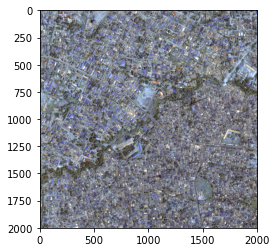

(3, 3, 1, 512, 512, 3)


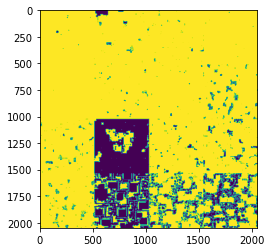

In [11]:
# path_to_dir = str(cfg.infer_data_tif_path) # '/home/root/tests/resources/infer_data_tif' # infer_data_tif

path_to_dir = '/home/root/TRAIN/raster/'
image_name = 'top_60cm_qb_area1.tif'
# for image_name in tif_files:
print('-----------------------------------------------------------')
print("Running prediction on image:  ", image_name)
# specify the repository where the input file is located and its name
# path_to_dir = '/home/root/data/volumes/datasets/baranquilla_full_40cm/' # baranquilla_merged_33_resampled_40cm
path_to_file_complete = os.path.join(path_to_dir, image_name)
# print("----------------------------------------------------------------------------------------------------")
# print(path_to_file_complete)
img = imageio.imread(path_to_file_complete)
plt.imshow(img)
plt.show()
patches = extract_patches(img)
print(patches.shape)
# print(patches.reshape((-1, 1024, 1024, 3)).shape)
image_size = img.shape
# print("image size :", image_size)
input_patch_size = (512, 512, 3)
padded_image_size = [math.ceil(image_size[i]/input_patch_size[i]) * (input_patch_size[i]) for i in range(3)]
# print("padded image size :", padded_image_size)
topad = []
for i in range(len(image_size)-1):
    if (padded_image_size[i] - image_size[i])%2 == 0:
        topad.append((int((padded_image_size[i]- image_size[i])/2), int((padded_image_size[i]- image_size[i])/2)))
    else:
        topad.append((int((padded_image_size[i]- image_size[i])//2), int((padded_image_size[i]- image_size[i])//2)+1))
topad.append((0,0))
# print(tuple(topad))
###
ret = np.pad(img, pad_width=tuple(topad), mode='reflect')
# print("Confirm new padded image size :", ret.shape)
###
# proceed to extract overlapping patches
ret_patches = extract_patches(ret, patch_shape=(512,512,3), extraction_step=512)
# print(ret_patches.shape)
# X = np.transpose(patches.reshape((-1, 32, 32, 3)), (0, 3, 1, 2))
# print(ret_patches.reshape((-1, 512, 512, 3)).shape)
# plt.imshow(ret)
# Extra padding step to account for patch overlap during prediction process
aug_img = np.pad(ret, pad_width=((256, 256), (256, 256), (0, 0)), mode='reflect')
# print("Check newly padded (augmented) image size :", aug_img.shape)
# plot augmented image
# plt.imshow(aug_img)
# proceed to extract overlapping patches
aug_patches = extract_patches(aug_img, patch_shape=(1024,1024,3), extraction_step=512)
topredict = aug_patches.reshape((-1, 1024, 1024, 3))
pred_aug_patches = []
for i in range(aug_patches.reshape((-1, 1024, 1024, 3)).shape[0]):
    pred_aug_patches.append(model(topredict[i,:,:,:][None, ...]/255.))
pred_aug_patchex = np.array(np.squeeze(pred_aug_patches))
(I,J,K) =  (ret.shape[0]//512, ret.shape[1]//512, 3)
reconst_img = np.empty((ret.shape[0],ret.shape[1]), float)
index = 0
for i in range(I):
    # print('j : ', j)
    for j in range(J):
        # print('i : ', i)
        reconst_img[512*i:512*(i+1), 512*j:512*(j+1)] = pred_aug_patchex[index,256:1024-256,256:1024-256] # aug_patches.reshape((-1, 640, 640, 3))[index,64:640-64,64:640-64,:]
        index += 1
    #
#
# print()
# print(reconst_img.shape)
plt.imshow(reconst_img)
reconst_img_origin = reconst_img[topad[0][0]:reconst_img.shape[0]-topad[0][1],topad[1][0]:reconst_img.shape[1]-topad[1][1]]
###
# np.save('predImg_output_xyz.npy', reconst_img_origin)
###
datenow = time.strftime("%Y%m%d-%H%M%S")
output_name = "Model_Segmentalist_infer_" + image_name + "_" + datenow + ".tif" # 'predictedImgOutput.tif'
output_path = cfg.predictions_data_tif_path / Path(output_name)
#     with rasterio.open(path_to_file_complete) as src:
#         profile = src.profile
#         profile.update(count=1)
#         with rasterio.open(output_path, 'w', **profile) as dst:
#             #
#             dst.write(tf.cast(reconst_img_origin*255., tf.uint8), indexes=1)

-----------------------------------------------------------
Running prediction on image:   Medellin_40cm.tif


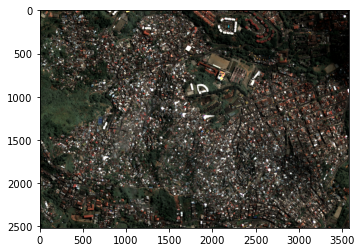

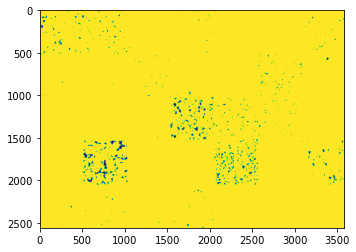

In [10]:
path_to_dir = '/home/root/tests/resources/train_data_tif/rasters/'
image_name = 'Medellin_40cm.tif'

print('-----------------------------------------------------------')
print("Running prediction on image:  ", image_name)
# specify the repository where the input file is located and its name
# path_to_dir = '/home/root/data/volumes/datasets/baranquilla_full_40cm/' # baranquilla_merged_33_resampled_40cm
path_to_file_complete = os.path.join(path_to_dir, image_name)
# print("----------------------------------------------------------------------------------------------------")
# print(path_to_file_complete)
img = imageio.imread(path_to_file_complete)
plt.imshow(img)
plt.show()
# patches = extract_patches(img)
# print(patches.shape)
# print(patches.reshape((-1, 1024, 1024, 3)).shape)
image_size = img.shape
# print("image size :", image_size)
input_patch_size = (512, 512, 3)
padded_image_size = [math.ceil(image_size[i]/input_patch_size[i]) * (input_patch_size[i]) for i in range(3)]
# print("padded image size :", padded_image_size)
topad = []
for i in range(len(image_size)-1):
    if (padded_image_size[i] - image_size[i])%2 == 0:
        topad.append((int((padded_image_size[i]- image_size[i])/2), int((padded_image_size[i]- image_size[i])/2)))
    else:
        topad.append((int((padded_image_size[i]- image_size[i])//2), int((padded_image_size[i]- image_size[i])//2)+1))
topad.append((0,0))
# print(tuple(topad))
###
ret = np.pad(img, pad_width=tuple(topad), mode='reflect')
# print("Confirm new padded image size :", ret.shape)
###
# proceed to extract overlapping patches
ret_patches = extract_patches(ret, patch_shape=(512,512,3), extraction_step=512)
# print(ret_patches.shape)
# X = np.transpose(patches.reshape((-1, 32, 32, 3)), (0, 3, 1, 2))
# print(ret_patches.reshape((-1, 512, 512, 3)).shape)
plt.imshow(ret)
# Extra padding step to account for patch overlap during prediction process
aug_img = np.pad(ret, pad_width=((256, 256), (256, 256), (0, 0)), mode='reflect')
# print("Check newly padded (augmented) image size :", aug_img.shape)
# plot augmented image
# plt.imshow(aug_img)
# proceed to extract overlapping patches
aug_patches = extract_patches(aug_img, patch_shape=(1024,1024,3), extraction_step=512)
topredict = aug_patches.reshape((-1, 1024, 1024, 3))
pred_aug_patches = []
for i in range(aug_patches.reshape((-1, 1024, 1024, 3)).shape[0]):
    pred_aug_patches.append(model(topredict[i,:,:,:][None, ...]/255.))
pred_aug_patchex = np.array(np.squeeze(pred_aug_patches))
(I,J,K) =  (ret.shape[0]//512, ret.shape[1]//512, 3)
reconst_img = np.empty((ret.shape[0],ret.shape[1]), float)
index = 0
for i in range(I):
    # print('j : ', j)
    for j in range(J):
        # print('i : ', i)
        reconst_img[512*i:512*(i+1), 512*j:512*(j+1)] = pred_aug_patchex[index,256:1024-256,256:1024-256] # aug_patches.reshape((-1, 640, 640, 3))[index,64:640-64,64:640-64,:]
        index += 1
    #
#
# print()
# print(reconst_img.shape)
plt.imshow(reconst_img)
plt.show()
reconst_img_origin = reconst_img[topad[0][0]:reconst_img.shape[0]-topad[0][1],topad[1][0]:reconst_img.shape[1]-topad[1][1]]
###
# np.save('predImg_output_xyz.npy', reconst_img_origin)
###
datenow = time.strftime("%Y%m%d-%H%M%S")
output_name = "Model_Segmentalist_infer_" + image_name + "_" + datenow + ".tif" # 'predictedImgOutput.tif'
output_path = cfg.predictions_data_tif_path / Path(output_name)
#     with rasterio.open(path_to_file_complete) as src:
#         profile = src.profile
#         profile.update(count=1)
#         with rasterio.open(output_path, 'w', **profile) as dst:
#             #
#             dst.write(tf.cast(reconst_img_origin*255., tf.uint8), indexes=1)

0.498046875


/opt/conda/envs/gim_cv_gpu/lib/python3.8/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning:

Low image data range; displaying image with stretched contrast.



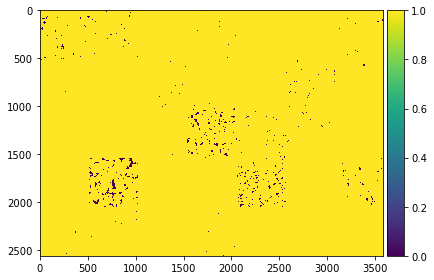

In [9]:
from skimage import data
from skimage.morphology import disk
from skimage.filters import threshold_otsu, rank
from skimage.util import img_as_ubyte

import matplotlib
import matplotlib.pyplot as plt

from skimage import data, io, filters


# load image
# image = data.imread("C:/structure/data/blobs.tif")
#split channels
image = reconst_img

# threshold
threshold = filters.threshold_otsu(image)
print(threshold)
thresholded = image >= threshold

# show result
io.imshow(thresholded)
io.show()